# Imports

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pickle

# Load Dataset

In [3]:
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")

matches.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


# Basic Cleaning

In [5]:
matches = matches[['id', 'city', 'winner']]

deliveries = deliveries.merge(
    matches,
    left_on='match_id',
    right_on='id',
    how='left'
)

# First Innings Total (TARGET)

In [6]:
first_innings = deliveries[deliveries['inning'] == 1]

target_df = (
    first_innings
    .groupby('match_id')['total_runs']
    .sum()
    .reset_index()
)

target_df.rename(columns={'total_runs': 'total_runs_x'}, inplace=True)

# Second Innings Data

In [7]:
second_innings = deliveries[deliveries['inning'] == 2]

second_innings = second_innings.merge(
    target_df,
    on='match_id',
    how='left'
)

# Feature Engineering

In [8]:
second_innings['current_score'] = (
    second_innings
    .groupby('match_id')['total_runs']
    .cumsum()
)

second_innings['balls_bowled'] = (
    second_innings['over'] * 6 + second_innings['ball']
)

second_innings['balls_left'] = 120 - second_innings['balls_bowled']

second_innings['runs_left'] = (
    second_innings['total_runs_x'] - second_innings['current_score']
)

second_innings['wickets'] = 10 - (
    second_innings
    .groupby('match_id')['player_dismissed']
    .count()
)

second_innings['cur_run_rate'] = np.where(
    second_innings['balls_bowled'] == 0,
    0,
    (second_innings['current_score'] * 6) / second_innings['balls_bowled']
)

second_innings['req_run_rate'] = np.where(
    second_innings['balls_left'] == 0,
    0,
    (second_innings['runs_left'] * 6) / second_innings['balls_left']
)

# Final Dataset

In [9]:
final_df = second_innings[[
    'batting_team',
    'bowling_team',
    'city',
    'runs_left',
    'balls_left',
    'wickets',
    'total_runs_x',
    'cur_run_rate',
    'req_run_rate',
    'winner'
]]

final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df.dropna(inplace=True)

final_df['result'] = final_df.apply(
    lambda x: 1 if x['batting_team'] == x['winner'] else 0,
    axis=1
)

final_df.head()

C:\Users\intel\AppData\Local\Temp\ipykernel_22276\3699924764.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\intel\AppData\Local\Temp\ipykernel_22276\3699924764.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)
C:\Users\intel\AppData\Local\Temp\ipykernel_22276\3699924764.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,cur_run_rate,req_run_rate,winner,result
1,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206,112,0.0,207,0.750000,11.035714,Sunrisers Hyderabad,0
2,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206,111,7.0,207,0.666667,11.135135,Sunrisers Hyderabad,0
3,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,204,110,10.0,207,1.800000,11.127273,Sunrisers Hyderabad,0
4,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,200,109,6.0,207,3.818182,11.009174,Sunrisers Hyderabad,0
5,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,196,108,1.0,207,5.500000,10.888889,Sunrisers Hyderabad,0


In [10]:
print(np.isinf(final_df.select_dtypes(include=np.number)).sum())
print(final_df.isna().sum())

runs_left       0
balls_left      0
wickets         0
total_runs_x    0
cur_run_rate    0
req_run_rate    0
result          0
dtype: int64
batting_team    0
bowling_team    0
city            0
runs_left       0
balls_left      0
wickets         0
total_runs_x    0
cur_run_rate    0
req_run_rate    0
winner          0
result          0
dtype: int64


# Features & Target

In [11]:
X = final_df.drop(['winner', 'result'], axis=1)
y = final_df['result']

print(X.columns)

Index(['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets', 'total_runs_x', 'cur_run_rate', 'req_run_rate'],
      dtype='object')


# Train/Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline

In [13]:
trf = ColumnTransformer(
    transformers=[
        (
            'cat',
            OneHotEncoder(drop='first', handle_unknown='ignore'),
            ['batting_team', 'bowling_team', 'city']
        )
    ],
    remainder='passthrough'
)

pipe = Pipeline([
    ('transform', trf),
    ('model', LogisticRegression(max_iter=1000))
])

# Train Model

In [14]:
pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('transform', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

# Accuracy

In [15]:
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


# Save Model

In [16]:
pickle.dump(pipe, open("pipe.pkl", "wb"))

# Quick Analytics

<Axes: xlabel='batting_team'>

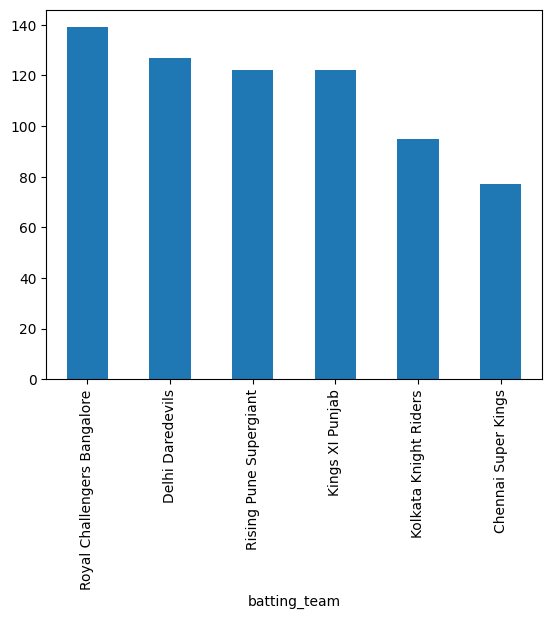

In [17]:
final_df['batting_team'].value_counts().head(6).plot(kind='bar')